In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt

Globals

In [2]:
NUM_CROPS = 1
IN_ROWS = 100
IN_COLS = 160
OUT_ROWS = 48
OUT_COLS = 48
Y1 = 10
X1 = 10
Y2 = Y1 + OUT_ROWS
X2 = X1 + OUT_COLS
CROP_COORDS_HARD = np.array([Y1, X1, Y2, X2])

SMALL_MODEL = False

TESTBENCH_TYPE = "VALUE_EQUALS_INDEX"
assert(TESTBENCH_TYPE in ["VALUE_EQUALS_INDEX"]) # ["REAL_DATA", "VALUE_EQUALS_INDEX", "RANDOM"])
if TESTBENCH_TYPE=="VALUE_EQUALS_INDEX":
    FP_FRAC = 0 # We just want integer values corresponding to the index of each pixel
    FP_INT = 15 # int(np.log2(IN_ROWS*IN_COLS)) + 1 
    FP_TOTAL = FP_FRAC + FP_INT + 1 # We'll keep it signed for simplicity
    STRING_INSERT = "_INDEX"
    VMAX = IN_ROWS*IN_COLS
elif TESTBENCH_TYPE=="REAL_DATA":
    FP_FRAC = 13
    FP_INT = 2
    FP_TOTAL = FP_FRAC + FP_INT + 1
    STRING_INSERT = ""
    VMAX = 1
elif TESTBENCH_TYPE=="RANDOM":
    FP_FRAC = 13
    FP_INT = 2
    FP_TOTAL = FP_FRAC + FP_INT + 1
    STRING_INSERT = "_RANDOM"
    VMAX = 1
else: raise NotImplementedError

REUSE_FACTOR = 32

print(f"FP_TOTAL: {FP_TOTAL}")
print(f"FP_INT: {FP_INT}")
print(f"FP_FRAC: {FP_FRAC}")

FP_TOTAL: 16
FP_INT: 15
FP_FRAC: 0


Helper functions

In [3]:
def float_to_fixed_point(value: float, total_bits: int, fractional_bits: int) -> str:
    """
    Convert a float to a fixed-point binary representation.
    
    :param value: Float value to convert.
    :param total_bits: Total number of bits for the representation.
    :param fractional_bits: Number of fractional bits.
    :return: Fixed-point binary string.
    """
    scale = 2 ** fractional_bits
    fixed_point_value = int(round(value * scale))
    
    # Handle two's complement representation for negative numbers
    if fixed_point_value < 0:
        fixed_point_value = (1 << total_bits) + fixed_point_value
    
    return f"{fixed_point_value:0{total_bits}b}"


def fixed_point_to_float(binary: str, fractional_bits: int) -> float:
    """
    Convert a fixed-point binary representation to a float.
    
    :param binary: Fixed-point binary string.
    :param fractional_bits: Number of fractional bits.
    :return: Float value.
    """
    total_bits = len(binary)
    int_value = int(binary, 2)
    
    # Handle two's complement for negative numbers
    if int_value >= (1 << (total_bits - 1)):
        int_value -= (1 << total_bits)
    
    return int_value / (2 ** fractional_bits)

In [4]:
fname_suffix = f"{IN_ROWS}x{IN_COLS}_to_{OUT_ROWS}x{OUT_COLS}x{NUM_CROPS}.bin"
fpath_img = f"tb_data/img_postcrop_INDEX_{fname_suffix}"
fpath_img_readin = f"tb_data/img_postcrop_INDEX_READIN_{fname_suffix}"
fpath_vout = f"tb_data/vout_postcrop_INDEX_{fname_suffix}"
fpath_hlsout = f"tb_data/hlsout_postcrop_INDEX_{fname_suffix}"

# Load input testbench data 

from binary

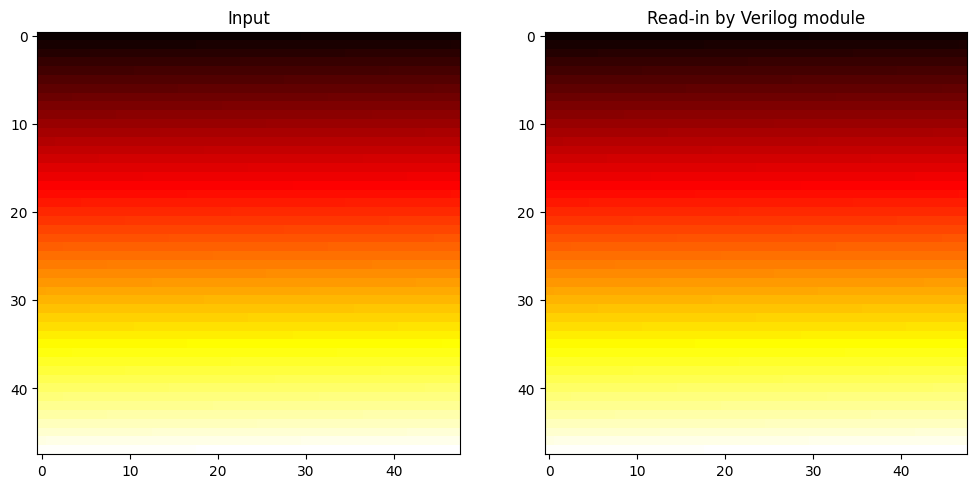

x_indeces: [0, 2305]


In [5]:
img = np.zeros((OUT_ROWS*OUT_COLS), dtype=np.int32)
with open(fpath_img, 'rb') as f:
    for i, line in enumerate(f.readlines()):

        x = str(line)
        x = x.replace("\\r\\n", "")
        x = x.replace("\\n", "")
        x = x.replace("b'", "")
        x = x.replace("'", "")
        val = fixed_point_to_float(x, FP_FRAC)
        img[i] = val
img = img.reshape((OUT_ROWS, OUT_COLS))

dest_idx = 0
x_indeces = []
img_readin = np.zeros((OUT_ROWS*OUT_COLS), dtype=np.int32)
with open(fpath_img_readin, 'rb') as f:
    for i, line in enumerate(f.readlines()):

        x = str(line)
        if "x" in x:
            x_indeces.append(i)
            continue
    
        x = x.replace("\\r\\n", "")
        x = x.replace("\\n", "")
        x = x.replace("b'", "")
        x = x.replace("'", "")
        val = fixed_point_to_float(x, FP_FRAC)
        img_readin[dest_idx] = val
        dest_idx += 1
img_readin = img_readin.reshape((OUT_ROWS, OUT_COLS))


fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.imshow(img, cmap='hot')
ax1.set_title("Input")
ax2.imshow(img_readin, cmap='hot')
ax2.set_title("Read-in by Verilog module")
plt.show(fig)
plt.close(fig)

print(f"x_indeces: {x_indeces}")

Beautiful - so we're reading in the data correctly. 

# Load output testbench data

In [6]:
vout_float = np.zeros(5)
hlsout_float = np.zeros(5)
with open(fpath_vout, "r") as f:
    for i, line in enumerate(f):
        vout_float[i] = fixed_point_to_float(line.strip(), FP_FRAC)

with open(fpath_hlsout, "r") as f:
    for i, line in enumerate(f):
        hlsout_float[i] = fixed_point_to_float(line.strip(), FP_FRAC)

print(f"vout: {vout_float}")
print(f"hlsout: {hlsout_float}")


vout: [ 16286.  22627.  11641.   3430. -19929.]
hlsout: [ 1257.  5961. 14967. -3218. 15550.]
